# Risks of Long-term Secondary Malignancies in Breast Cancer Patients Treated with Adjuvant Chemotherapy

[Benjamin Chan](http://careers.stackoverflow.com/benjaminchan)  

In [1]:
message(sprintf("Run date: %s", Sys.time()))

Run date: 2016-06-25 15:31:58


Load packages.

In [2]:
if (!require(openxlsx)) {install.packages("openxlsx", dependencies=TRUE, repos="https://cloud.r-project.org")}
library(openxlsx)
if (!require(data.table)) {install.packages("data.table", dependencies=TRUE, repos="https://cloud.r-project.org")}
library(data.table)

Loading required package: openxlsx
Loading required package: data.table


## Load data

Load the data from [GitHub](https://github.com/benjamin-chan/SecMalAfterBreastCaACT).

In [3]:
repo <- "https://github.com/benjamin-chan/SecMalAfterBreastCaACT"
url <- paste0(repo, "/raw/26115dab1eb2b075d40f545514a03c3b30cde6b4/SecondaryMalignancies_Data_BG_3_4.xlsx")
f <- tempfile()
download.file(url, f, mode="wb")
file.info(f)[c("size", "mtime")]
sheets <- getSheetNames(f)
# sheets
D <- read.xlsx(f, sheet = sheets[1], startRow = 3, colNames = FALSE)
D <- data.table(D)
oldnames <- names(D)
newnames <- c("id",
              "authorYear",
              "trial",
              "quality",
              "arm",
              "nRandomized",
              "nITT",
              # "pctCompletingTx",
              "medianFU",
              "regimen",
              "anthracyclineType",
              "anthracyclineTotalDose",
              "anthracyclineDuration",
              "anthracyclineCourses",
              "cyclophosphamideDose",
              "cyclophosphamideDuration",
              "cyclophosphamideCourses",
              "taxaneType",
              "taxaneTotalDose",
              "taxaneDuration",
              "taxaneCourses",
              "fluoroucilTotalDose",
              "fluoroucilDuration",
              "fluoroucilCourses",
              "otherTxDetails",
              "malAML",
              "malMDS",
              "malAMLOrMDS",
              "malNonBreastSolid",
              "malNonBreastSolidType",
              "malOtherBloodCancers",
              "malSMRelatedDeaths",
              "malSecondPrimary",
              "NOTES")
setnames(D, oldnames, newnames[1:33])

                                  size               mtime
/tmp/RtmpfQaBG7/file4e2c40161d2b 59619 2016-06-25 15:31:59

## Tidy data

Create a `rowid` variable.
This will be handy later.

In [4]:
D <- D[, rowid := .I]

Fix some minor data entry inconsistencies.

In [5]:
D <- D[grep("Nitz", authorYear), authorYear := gsub("2014$", "2014)", authorYear)]
D <- D[grep("Wolmark", authorYear), authorYear := gsub(", 2001$", " (2001)", authorYear)]

Input missing data for Bergh (2000); row was split.

In [6]:
col <- grep("^cyclophosphamide", names(D), invert = TRUE)
D[11, col] <- D[10, col, with = FALSE]
# D[11, ]
# D[10, ]

Fix trial column for Romond (2005).

In [7]:
D <- D[grep("Romond", authorYear), trial := gsub("&N", "& N", trial)]

Make `medianFU` numeric.

In [8]:
D <- D[grep("-", medianFU, invert = TRUE), medianFUNum := round(as.numeric(medianFU), digits = 2)]
x <- D[grep("-", medianFU), medianFU]
x <- as.numeric(unlist(strsplit(x, "-")))
x1 <- x[seq(1, length(x), 2)]
x2 <- x[seq(2, length(x), 2)]
xbar <- rowMeans(cbind(x1, x2))
D <- D[grep("-", medianFU), medianFUNum := xbar]
D <- D[,
       `:=` (medianFUChar = medianFU,
             medianFU = medianFUNum,
             medianFUNum = NULL)]
unique(D[as.character(medianFU) != medianFUChar, .(medianFU, medianFUChar)])
D <- D[, medianFUChar := NULL]

,medianFU,medianFUChar
1,38.3,38.299999999999997
2,73,71-75
3,99.6,99.600000000000009
4,28.8,28.799999999999997


Recode mal* values of `NR` and `-` to `NA`.

In [9]:
recode <- function(x) {
    missval <- c("-", "NR", " ")
    vec <- D[, get(x)]
    vec[vec %in% missval] <- NA
    vec
}
col <- grep("^mal", names(D), value = TRUE)
for (i in 1:length(col)) {
    D[, col[i]] <- recode(col[i])
}

Substitute non-numeric text in mal* values.

In [10]:
substitute <- function(x) {
    vec <- D[, get(x)]
    vec <- gsub("[[:alpha:]]", "", vec)
    vec
}
col <- grep("^mal", names(D), value = TRUE)
for (i in 1:4) {
    # Only substitute a subset of mal* columns
    D[, col[i]] <- substitute(col[i])
}

Convert mal* values to numeric.

In [11]:
for (i in 1:4) {
    # Only convert a subset of mal* columns
    D <- D[, col[i] := as.numeric(get(col[i]))]
}

The `malAMLOrMDS` column, as entered, captures number of AML or MDS malignancies if the study reported them grouped as opposed to separately.
If the study reported them as separately, then these counts are captures in the `malAML` and `malMDS` columns.
I.e., the `malAML`, `malMDS`, and `malAMLOrMDS` columns are mutually exclusive counts.
We want to create another column, `malAMLOrMDSTotal`, to be non-mutually exclusive from `malAML`, `malMDS`, and `malAMLOrMDS`.
If none of the `malAML`, `malMDS`, and `malAMLOrMDS` values are populated, then set `malAMLOrMDSTotal` to `NA`, also.
NOTE: Couldn't get this to work: [http://stackoverflow.com/a/16513949/1427069](http://stackoverflow.com/a/16513949/1427069).

In [12]:
s <- sample(D[, rowid], 12)
malAMLOrMDSTotal <- rowSums(D[, .(malAML, malMDS, malAMLOrMDS)], na.rm=TRUE)
D <- D[, malAMLOrMDSTotal := malAMLOrMDSTotal]
D <- D[is.na(malAML) & is.na(malMDS) & is.na(malAMLOrMDS), malAMLOrMDSTotal := NA]
D[s, .(rowid, malAML, malMDS, malAMLOrMDS, malAMLOrMDSTotal)]

,rowid,malAML,malMDS,malAMLOrMDS,malAMLOrMDSTotal
1,46,2,0,NA,2
2,2,NA,NA,NA,NA
3,25,NA,NA,7,7
4,63,NA,NA,NA,NA
5,10,0,0,NA,0
6,68,NA,NA,NA,NA
7,76,1,0,NA,1
8,95,0,NA,NA,0
9,77,NA,NA,NA,NA
10,78,NA,NA,NA,NA


Remove text from `nITT` column.

In [13]:
D <- D[authorYear == "Misset (1996)" & arm == 2, nITT := "137"]
D <- D[authorYear == "Fumoleu (2003)" & arm == 1, nITT := "210"]
D <- D[authorYear == "Fumoleu (2003)" & arm == 2, nITT := "197"]
D <- D[authorYear == "Fumoleu (2003)" & arm == 3, nITT := "195"]
D <- D[, nITT := as.integer(nITT)]

Clean up the `regimen` and `dose` columns.
Output to [regimens.md](regimens.md) for checking.

In [14]:
D <- D[, regimen := gsub("\\s$", "", regimen)]
D <- D[, regimen := gsub("\\r\\n", " ", regimen)]
doseVar <- grep("dose", names(D), ignore.case = TRUE, value = TRUE)
for (i in 1:length(doseVar)) {
    D <- D[, doseVar[i] := gsub("\\r\\n", " ", get(doseVar[i]))]
}
write.table(D[, .N, c("regimen", doseVar), with = TRUE][order(regimen)],
            file = "regimens.md",
            sep = " | ", quote = FALSE,
            row.names = FALSE)
file.info("regimens.md")

            size isdir mode               mtime               ctime
regimens.md 2150 FALSE  664 2016-06-25 15:32:00 2016-06-25 15:32:00
                          atime  uid  gid  uname grname
regimens.md 2016-06-25 15:22:22 1000 1000 ubuntu ubuntu

Calculate cumulative dose: $\text{total dose} \times \text{number of courses}$.

In [15]:
D <- D[, anthracyclineTotalDose := as.numeric(anthracyclineTotalDose)]
D <- D[authorYear == "Bergh (2000)" & regimen == "FEC\nTailored", anthracyclineTotalDose := 75]
D <- D[authorYear == "Henderson (2003)", anthracyclineTotalDose := 75]
D <- D[authorYear == "Colleoni (2009)" & regimen == "AC-CMF", anthracyclineTotalDose := 75]
D <- D[, cyclophosphamideDose := as.numeric(cyclophosphamideDose)]
D <- D[authorYear == "Bergh (2000)" & regimen == "FEC\nTailored", cyclophosphamideDose := 900]
D <- D[authorYear == "Henderson (2003)", anthracyclineTotalDose := 75]
D <- D[, taxaneCourses := as.numeric(taxaneCourses)]
D <- D[authorYear == "Shulman (2014)" & regimen == "T" & arm == 3, taxaneCourses := 4]
D <- D[authorYear == "Shulman (2014)" & regimen == "T" & arm == 4, taxaneCourses := 6]
D <- D[, fluoroucilTotalDose := as.numeric(fluoroucilTotalDose)]
D <- D[authorYear == "Bergh (2000)" & regimen == "FEC\nTailored", fluoroucilTotalDose := 600]
D <- D[authorYear == "Joensuu (2012)" & regimen == "TX-CEX", fluoroucilTotalDose := NA]
D <- D[,
       `:=` (anthracyclineCumulDose = anthracyclineTotalDose * anthracyclineCourses,
             cyclophosphamideCumulDose = cyclophosphamideDose * cyclophosphamideCourses,
             taxaneCumulDose = as.numeric(taxaneTotalDose) * taxaneCourses,
             fluoroucilCumulDose = fluoroucilTotalDose * fluoroucilCourses)]

Warning message:
In eval(expr, envir, enclos): NAs introduced by coercionWarning message:
In eval(expr, envir, enclos): NAs introduced by coercionWarning message:
In eval(expr, envir, enclos): NAs introduced by coercionWarning message:
In eval(expr, envir, enclos): NAs introduced by coercion

Check.

In [16]:
head(D[!is.na(anthracyclineCumulDose),
       .(authorYear, regimen, anthracyclineCumulDose, anthracyclineTotalDose, anthracyclineCourses)])
head(D[!is.na(cyclophosphamideCumulDose),
       .(authorYear, regimen, cyclophosphamideCumulDose, cyclophosphamideDose, cyclophosphamideCourses)])
head(D[!is.na(taxaneCumulDose),
       .(authorYear, regimen, taxaneCumulDose, taxaneTotalDose, taxaneCourses)])
head(D[!is.na(fluoroucilCumulDose),
       .(authorYear, regimen, fluoroucilCumulDose, fluoroucilTotalDose, fluoroucilCourses)])

,authorYear,regimen,anthracyclineCumulDose,anthracyclineTotalDose,anthracyclineCourses
1,Fisher (1990),AC,240,60,4
2,Fisher (1990),AC-CMF,240,60,4
3,Misset (1996),AVCF,360,30,12
4,Fisher (1999),AC,240,60,4
5,Fisher (1999),AC,240,60,4
6,Fisher (1999),AC,240,60,4


,authorYear,regimen,cyclophosphamideCumulDose,cyclophosphamideDose,cyclophosphamideCourses
1,Fisher (1990),AC,2400,600,4
2,Fisher (1990),AC-CMF,2400,600,4
3,Misset (1996),AVCF,14400,1200,12
4,Fisher (1999),AC,4800,1200,4
5,Fisher (1999),AC,4800,2400,2
6,Fisher (1999),AC,9600,2400,4


,authorYear,regimen,taxaneCumulDose,taxaneTotalDose,taxaneCourses
1,Citron (2003),A-T-C,700,175,4
2,Citron (2003),A-T-C,700,175,4
3,Citron (2003),AC-T,700,175,4
4,Citron (2003),AC-T,700,175,4
5,Francis (2008),A-T-CMF,300,100,3
6,Francis (2008),AT-CMF,300,75,4


,authorYear,regimen,fluoroucilCumulDose,fluoroucilTotalDose,fluoroucilCourses
1,Misset (1996),AVCF,19200,1600,12
2,Venturini (2005),FEC,3600,600,6
3,Venturini (2005),FEC,3600,600,6
4,Martin (2010),FAC,3000,500,6
5,Roche (2006),FEC,3000,500,6
6,Roche (2006),FEC-T,1500,500,3


### Manual tidying

After an early round of analysis, we realized there were some `nITT` data entry errors in the commit [26115da](https://github.com/benjamin-chan/SecMalAfterBreastCaACT/raw/26115dab1eb2b075d40f545514a03c3b30cde6b4/SecondaryMalignancies_Data_BG_3_4.xlsx) (Jun 1, 2016) spreadsheet.

In [17]:
D <- D[authorYear == "Mamounas (2005)" & nITT == 1528, `:=` (nITTOld = nITT, nITT = 1529, isFixed = TRUE)]
D <- D[authorYear == "Fumoleu (2003)" & nITT == 210, `:=` (nITTOld = nITT, nITT = 212, isFixed = TRUE)]
D <- D[authorYear == "Fumoleu (2003)" & nITT == 197, `:=` (nITTOld = nITT, nITT = 209, isFixed = TRUE)]
D <- D[authorYear == "Fumoleu (2003)" & nITT == 195, `:=` (nITTOld = nITT, nITT = 200, isFixed = TRUE)]
D <- D[authorYear == "Fargeot (2004)" & nITT == 155, `:=` (nITTOld = nITT, nITT = 164, isFixed = TRUE)]
D <- D[authorYear == "Fargeot (2004)" & nITT == 163, `:=` (nITTOld = nITT, nITT = 174, isFixed = TRUE)]
D <- D[authorYear == "Kerbrat (2007)" & nITT == 235, `:=` (nITTOld = nITT, nITT = 241, isFixed = TRUE)]
D <- D[authorYear == "Kerbrat (2007)" & nITT == 236, `:=` (nITTOld = nITT, nITT = 241, isFixed = TRUE)]
D <- D[authorYear == "Fisher (1997)" & nITT == 763, `:=` (nITTOld = nITT, nITT = 767, isFixed = TRUE)]
D <- D[authorYear == "Fisher (1997)" & nITT == 771, `:=` (nITTOld = nITT, nITT = 772, isFixed = TRUE)]
D <- D[authorYear == "Bonneterre (2005)" & nITT == 271, `:=` (nITTOld = nITT, nITT = 289, isFixed = TRUE)]
D <- D[authorYear == "Bonneterre (2005)" & nITT == 266, `:=` (nITTOld = nITT, nITT = 276, isFixed = TRUE)]
D <- D[authorYear == "Roche (2006)" & nITT == 163, `:=` (nITTOld = nITT, nITT = 164, isFixed = TRUE)]
D <- D[authorYear == "Roche (2006)" & nITT == 168, `:=` (nITTOld = nITT, nITT = 169, isFixed = TRUE)]
D <- D[authorYear == "Shulman (2014)" & nITT == 1107, `:=` (nITTOld = nITT, nITT = 1142, isFixed = TRUE)]
D <- D[authorYear == "Shulman (2014)" & nITT ==  766, `:=` (nITTOld = nITT, nITT =  789, isFixed = TRUE)]
D <- D[authorYear == "Shulman (2014)" & nITT == 1119, `:=` (nITTOld = nITT, nITT = 1151, isFixed = TRUE)]
D <- D[authorYear == "Shulman (2014)" & nITT ==  782, `:=` (nITTOld = nITT, nITT =  789, isFixed = TRUE)]
D <- D[authorYear == "Swain (2013)" & nITT == 1617, `:=` (nITTOld = nITT, nITT = 1630, isFixed = TRUE)]
D <- D[authorYear == "Swain (2013)" & nITT == 1624, `:=` (nITTOld = nITT, nITT = 1634, isFixed = TRUE)]
D <- D[authorYear == "Swain (2013)" & nITT == 1618, `:=` (nITTOld = nITT, nITT = 1630, isFixed = TRUE)]
D[isFixed == TRUE, .(authorYear, regimen, nITTOld, nITT)]
D <- D[, `:=` (nITTOld = NULL, isFixed = NULL)]

,authorYear,regimen,nITTOld,nITT
1,Mamounas (2005),AC,1528,1529
2,Fumoleu (2003),FEC 50,210,212
3,Fumoleu (2003),3 FEC 50,197,209
4,Fumoleu (2003),FEC 75,195,200
5,Fargeot (2004),Tamoxifen,155,164
6,Fargeot (2004),EPI-Tam,163,174
7,Kerbrat (2007),FEC,235,241
8,Kerbrat (2007),E+Vnr,236,241
9,Fisher (1997),AC,763,767
10,Fisher (1997),AC,771,772


We also made the decision to use the AML/MDS outcomes reported in Perez (2011) as the outcomes for Romond (2005) since they study the same cohort. Other edits to *AML or MDS* malignancy outcome were needed, as well.

In [18]:
D <- D[authorYear == "Martin (2010)" & regimen == "TAC",
      `:=` (malAMLOrMDSTotalOld = malAMLOrMDSTotal, malAMLOrMDSTotal = 0, isFixed = TRUE)]
D <- D[authorYear == "Martin (2010)" & regimen == "FAC",
      `:=` (malAMLOrMDSTotalOld = malAMLOrMDSTotal, malAMLOrMDSTotal = 0, isFixed = TRUE)]
D <- D[authorYear == "Romond (2005)" & regimen == "AC-T",
      `:=` (malAMLOrMDSTotalOld = malAMLOrMDSTotal, malAMLOrMDSTotal = 2, isFixed = TRUE)]
D <- D[authorYear == "Romond (2005)" & regimen == "ACT-T-Trast",
      `:=` (malAMLOrMDSTotalOld = malAMLOrMDSTotal, malAMLOrMDSTotal = 1, isFixed = TRUE)]
D <- D[authorYear == "Del Mastro (2015)",
      `:=` (malAMLOrMDSTotalOld = malAMLOrMDSTotal, malAMLOrMDSTotal = 0, isFixed = TRUE)]
D <- D[authorYear == "Del Mastro (2015)" & regimen == "EC-T" & nITT == 502,
      `:=` (malAMLOrMDSTotalOld = malAMLOrMDSTotal, malAMLOrMDSTotal = 2, isFixed = TRUE)]
D[isFixed == TRUE, .(authorYear, regimen, nITT, malAMLOrMDSTotalOld, malAMLOrMDSTotal)]
D <- D[, `:=` (malAMLOrMDSTotalOld = NULL, isFixed = NULL)]

,authorYear,regimen,nITT,malAMLOrMDSTotalOld,malAMLOrMDSTotal
1,Martin (2010),TAC,539,NA,0
2,Martin (2010),FAC,521,NA,0
3,Romond (2005),AC-T,872,NA,2
4,Romond (2005),ACT-T-Trast,864,NA,1
5,Del Mastro (2015),EC-T,545,NA,0
6,Del Mastro (2015),FEC-T,544,NA,0
7,Del Mastro (2015),EC-T,502,0,2
8,Del Mastro (2015),FEC-T,500,NA,0


Deduplicate.

In [19]:
n0 <- nrow(D)
setkey(D, authorYear, trial, arm)
D <- unique(D)
message(sprintf("Removed %d duplicate row(s) (%.03g%%)", n0 - nrow(D), (n0 - nrow(D)) / n0 * 100))

Removed 1 duplicate row(s) (1.03%)


## Summarize

Define some functions.

In [20]:
scale <- 1e4
calcPct <- function (x, n) {
  prec <- "%.3g"
  sprintf(paste0(prec, "%%"),
          median(x / n, na.rm = TRUE) * 100)
}
calcRate <- function (x, n, y) {
  prec <- "%.3g"
  py <- scale
  sprintf(paste(prec, "per %s p-y"),
          median(x / (n * (y / 12)), na.rm=TRUE) * py,
          py)
}

Summarize the regimens.
Output to [summaryRegimens.md](summaryRegimens.md) for checking.

In [21]:
D <- D[,
       `:=` (isAnthra = !is.na(anthracyclineTotalDose),
             isCyclo = !is.na(cyclophosphamideDose),
             isTaxane = !is.na(taxaneTotalDose),
             isFluoro = !is.na(fluoroucilTotalDose))]
D1 <- melt(D,
           id.vars=c("id", "authorYear", "arm",
                     "isAnthra", "anthracyclineCumulDose",
                     "isCyclo", "cyclophosphamideCumulDose",
                     "isTaxane", "taxaneCumulDose",
                     "isFluoro", "fluoroucilCumulDose",
                     "nITT", "medianFU"),
           measure.vars=c("malAML", "malMDS", "malAMLOrMDSTotal", "malNonBreastSolid"),
           value.name="malN",
           variable.name="malType")

D1 <- D1[, malType := gsub("^mal", "", malType)]
D1 <- D1[, malType := factor(malType,
                             levels=c("AML", "MDS", "AMLOrMDSTotal", "NonBreastSolid"),
                             labels=c("AML", "MDS", "AML or MDS", "Non-Breast Solid"))]
D1 <- D1[, py := nITT * (medianFU / 12)]
D1 <- D1[, rate := malN / py * scale]
summaryRegimens <- D1[,
                      .(totalN = sum(nITT, na.rm = TRUE),
                        totalPersonYears = round(sum(py, na.rm = TRUE)),
                        totalMalignancies = sum(malN, na.rm = TRUE),
                        medianPct = calcPct(malN, nITT),
                        medianRate = calcRate(malN, nITT, medianFU)),
                      .(isAnthra,
                        isCyclo,
                        isTaxane,
                        isFluoro,
                        malType)]
summaryRegimens <- summaryRegimens[order(-isAnthra, -isCyclo, -isTaxane, -isFluoro, malType)]
write.table(summaryRegimens,
            file = "summaryRegimens.md",
            sep = " | ", quote = FALSE,
            row.names = FALSE)
file.info("summaryRegimens.md")

                   size isdir mode               mtime               ctime
summaryRegimens.md 2882 FALSE  664 2016-06-25 15:32:00 2016-06-25 15:32:00
                                 atime  uid  gid  uname grname
summaryRegimens.md 2016-06-25 15:22:27 1000 1000 ubuntu ubuntu

## Meta-regression

Estimate meta-regression models for log transformed incidence rate.
Model is

$$\frac{y_i}{\text{py}_i} = \beta x_i + \sigma_\text{study}$$

Or

$$\frac{y_i}{\text{py}_i} = \beta x_{\text{high dose}, i} + \sigma_\text{study}$$

Models were estimated using the `rma.mv()` function from the metafor` package for R.

In [22]:
library(metafor)
citation("metafor")

Loading required package: Matrix
Loading 'metafor' package (version 1.9-8). For an overview 
and introduction to the package please type: help(metafor).



To cite the metafor package in publications, please use:

  Viechtbauer, W. (2010). Conducting meta-analyses in R with the
  metafor package. Journal of Statistical Software, 36(3), 1-48. URL:
  http://www.jstatsoft.org/v36/i03/

A BibTeX entry for LaTeX users is

  @Article{,
    title = {Conducting meta-analyses in {R} with the {metafor} package},
    author = {Wolfgang Viechtbauer},
    journal = {Journal of Statistical Software},
    year = {2010},
    volume = {36},
    number = {3},
    pages = {1--48},
    url = {http://www.jstatsoft.org/v36/i03/},
  }


Define meta-regression functions.

In [23]:
pvalToChar <- function (p) {
  if (p < 0.001) {
    pvalue <- "p < 0.001"
  } else {
    pvalue <- sprintf("p = %.03f", p)
  }
  pvalue
}
metareg <- function (D) {
  require(metafor)
  D <- D[!(is.na(x) | is.na(rate) | is.na(nITT) | is.na(malType))]
  xData <- unique(D[, .(drug, x, xHighDose, malType)])
  D <- escalc("IRLN", xi=malN, ti=py, data=D)
  randomEffect <- list(~ 1 | id)
  MLin <- rma.mv(yi ~ x, vi, random=randomEffect, data=D)
  MBin <- rma.mv(yi ~ xHighDose, vi, random=randomEffect, data=D)
  pvalueLin <- MLin$pval[which(row.names(MLin$b) == "x")]
  pvalueBin <- MBin$pval[which(row.names(MBin$b) == "xHighDoseTRUE")]
  predLin <- invLogit(predict(MLin, xData[, x])[["pred"]]) * scale
  predBin <- invLogit(predict(MBin, xData[, xHighDose])[["pred"]]) * scale
  pred <- data.table(xData, predLin, predBin, scale)
  setorder(pred, x)
  list(rmaLin = MLin,
       rmaBin = MBin,
       pvalueLin = pvalToChar(pvalueLin),
       pvalueBin = pvalToChar(pvalueBin),
       pred = pred)
}
plotreg <- function (M, D, title, xlab, xbreaks, xscale) {
  require(ggplot2)
  require(RColorBrewer)
  require(tools)
  pvalues <- c(M$pvalueLin, M$pvalueBin)
  x <- seq(min(M$rmaLin$X[, "x"]), max(M$rmaLin$X[, "x"]), length.out=100)
  yhat1 <- unique(data.table(malType = mal,
                             x,
                             yhat = invLogit(predict(M$rmaLin, x)[["pred"]]) * scale))
  xHighDose <- as.logical(M$rmaBin$X[, "xHighDoseTRUE"])
  yhat2 <- unique(data.table(malType = mal,
                           xHighDose,
                             yhat = invLogit(predict(M$rmaBin, xHighDose)[["pred"]]) * scale))
  D <- D[!(is.na(x) | is.na(rate) | is.na(nITT) | is.na(malType))]
  D <- D[, malType := droplevels(malType)]
  steps <- merge(D[, .(min = min(x), max = max(x)), .(malType, xHighDose)],
                 yhat2,
                 by=c("malType", "xHighDose"))
  steps <- melt(steps, id.vars=c("malType", "xHighDose", "yhat"), measure.vars=c("min", "max"), value.name="x")
  annoLin <- data.frame(x=Inf, y=1.2, label=pvalues[c(1)], malType=levels(D[, malType]))
  annoBin <- data.frame(x=Inf, y=1.4, label=pvalues[c(2)], malType=levels(D[, malType]))
  pal <- brewer.pal(4, name="RdBu")
  G <- ggplot(D, aes(x=x * xscale, y=rate + 1/2, size=nITT / min(nITT, na.rm=TRUE)))
  G <- G + geom_point(alpha=1/3)
  G <- G + geom_line(data=yhat1, aes(x=x * xscale, y=yhat), inherit.aes=FALSE, color=pal[4])
  G <- G + geom_step(data=steps, aes(x=x * xscale, y=yhat), inherit.aes=FALSE, color=pal[1])
  G <- G + geom_text(data=annoLin,
                     aes(x, y, label=label), inherit.aes=FALSE, hjust=1, color=pal[4])
  G <- G + geom_text(data=annoBin,
                     aes(x, y, label=label), inherit.aes=FALSE, hjust=1, color=pal[1])
  G <- G + scale_x_log10(xlab, breaks=xbreaks)
  G <- G + scale_y_log10(sprintf("Rate per %s person-years", format(scale, big.mark=",")))
  G <- G + labs(title=title)
  G <- G + theme_bw()
  G <- G + theme(legend.position="none")
  filename <- gsub("\\s+",
                   "",
                   toTitleCase(paste(gsub("[[:punct:]]", "", title),
                                     gsub("cumulative dose", "", xlab),
                                     sep="_")))
  ggsave(filename=sprintf("%s.png", filename))
  write.csv(D, file=sprintf("%s.csv", filename), row.names=FALSE, quote=FALSE)
  M$pred[, x := x * xscale]
  write.csv(M$pred, file=sprintf("%s_Pred.csv", filename), row.names=FALSE, quote=FALSE)
  show(file.info(c(sprintf("%s.png", filename), sprintf("%s.csv", filename)))[c("size", "mtime")])
  G
}
invLogit <- function (x) {
  exp(x) / (1 + exp(x))
}

Dichotomoize cumulative doses

* Cyclophosphamide
    * $\lt 2400$
    * $\ge 2400$
* Taxane
    * $\lt 500$
    * $\ge 500$

In [24]:
D2 <- D1[isCyclo == TRUE,
         .(id = factor(id),
           authorYear,
           isCyclo,
           xCyc = cyclophosphamideCumulDose / 1e3,
           xCycHighDose = cyclophosphamideCumulDose >= 2400,
           xTax = taxaneCumulDose / 1e2,
           xTaxHighDose = taxaneCumulDose >= 500,
           isAnthra,
           isTaxane,
           isFluoro,
           nITT,
           medianFU,
           malType,
           malN,
           py,
           rate)]

### AML/MDS

* Fit the models
* Show model summaries
* Plot the predicted values

In [25]:
mal <- "AML or MDS"
D3 <- D2[malType == mal]

$rmaLin

Multivariate Meta-Analysis Model (k = 56; method: REML)

Variance Components: 

            estim    sqrt  nlvls  fixed  factor
sigma^2    0.1693  0.4115     26     no      id

Test for Residual Heterogeneity: 
QE(df = 54) = 67.8113, p-val = 0.0980

Test of Moderators (coefficient(s) 2): 
QM(df = 1) = 4.4383, p-val = 0.0351

Model Results:

         estimate      se      zval    pval    ci.lb    ci.ub     
intrcpt   -7.6135  0.2258  -33.7187  <.0001  -8.0560  -7.1709  ***
x          0.1182  0.0561    2.1067  0.0351   0.0082   0.2281    *

---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1 


$rmaBin

Multivariate Meta-Analysis Model (k = 56; method: REML)

Variance Components: 

            estim    sqrt  nlvls  fixed  factor
sigma^2    0.2447  0.4946     26     no      id

Test for Residual Heterogeneity: 
QE(df = 54) = 81.5431, p-val = 0.0091

Test of Moderators (coefficient(s) 2): 
QM(df = 1) = 0.4988, p-val = 0.4800

Model Results:

               estimate 

Loading required package: ggplot2
Loading required package: RColorBrewer
Loading required package: tools
Saving 6.67 x 6.67 in image


                                size               mtime
AMLorMDS_Cyclophosphamide.png 154175 2016-06-25 15:32:02
AMLorMDS_Cyclophosphamide.csv   7240 2016-06-25 15:32:02


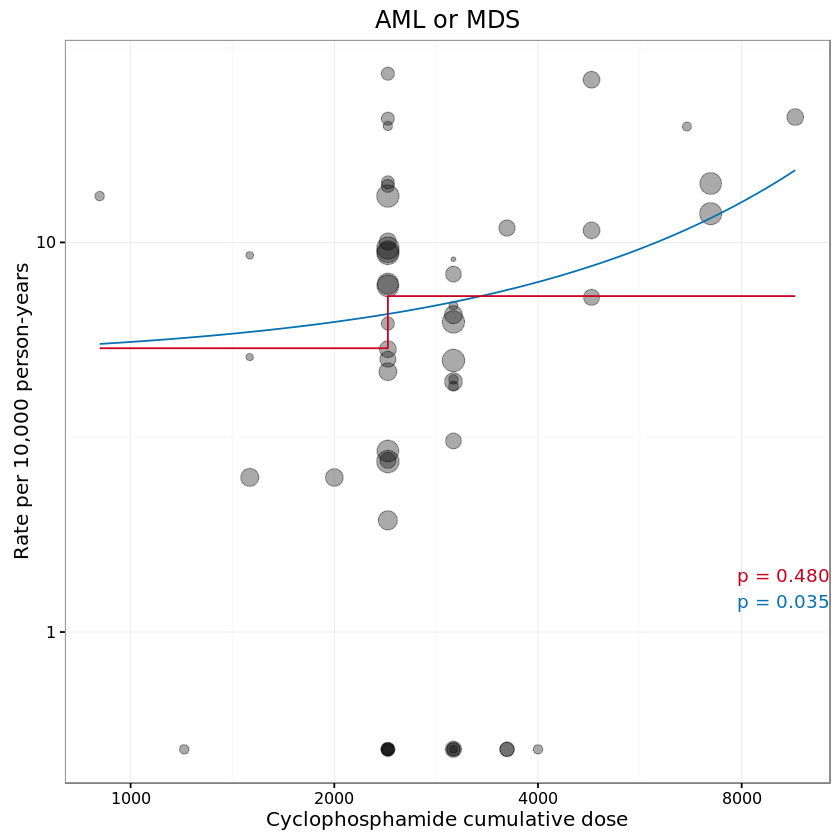

In [26]:
D3 <- D3[, `:=` (drug = "Cyclophosphamide", x = xCyc, xHighDose = xCycHighDose)]
M <- metareg(D3)
M
plotreg(M,
        D3,
        mal,
        "Cyclophosphamide cumulative dose",
        1e3 * c(0.5, 1, 2, 4, 8, 16),
        1e3)

$rmaLin

Multivariate Meta-Analysis Model (k = 23; method: REML)

Variance Components: 

            estim    sqrt  nlvls  fixed  factor
sigma^2    0.2197  0.4687     13     no      id

Test for Residual Heterogeneity: 
QE(df = 21) = 24.4406, p-val = 0.2722

Test of Moderators (coefficient(s) 2): 
QM(df = 1) = 3.1858, p-val = 0.0743

Model Results:

         estimate      se      zval    pval    ci.lb    ci.ub     
intrcpt   -8.4951  0.6857  -12.3883  <.0001  -9.8391  -7.1511  ***
x          0.1904  0.1067    1.7849  0.0743  -0.0187   0.3995    .

---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1 


$rmaBin

Multivariate Meta-Analysis Model (k = 23; method: REML)

Variance Components: 

            estim    sqrt  nlvls  fixed  factor
sigma^2    0.1606  0.4008     13     no      id

Test for Residual Heterogeneity: 
QE(df = 21) = 21.3734, p-val = 0.4364

Test of Moderators (coefficient(s) 2): 
QM(df = 1) = 4.6523, p-val = 0.0310

Model Results:

               estimate 

Saving 6.67 x 6.67 in image


                      size               mtime
AMLorMDS_Taxane.png 113301 2016-06-25 15:32:03
AMLorMDS_Taxane.csv   2816 2016-06-25 15:32:03


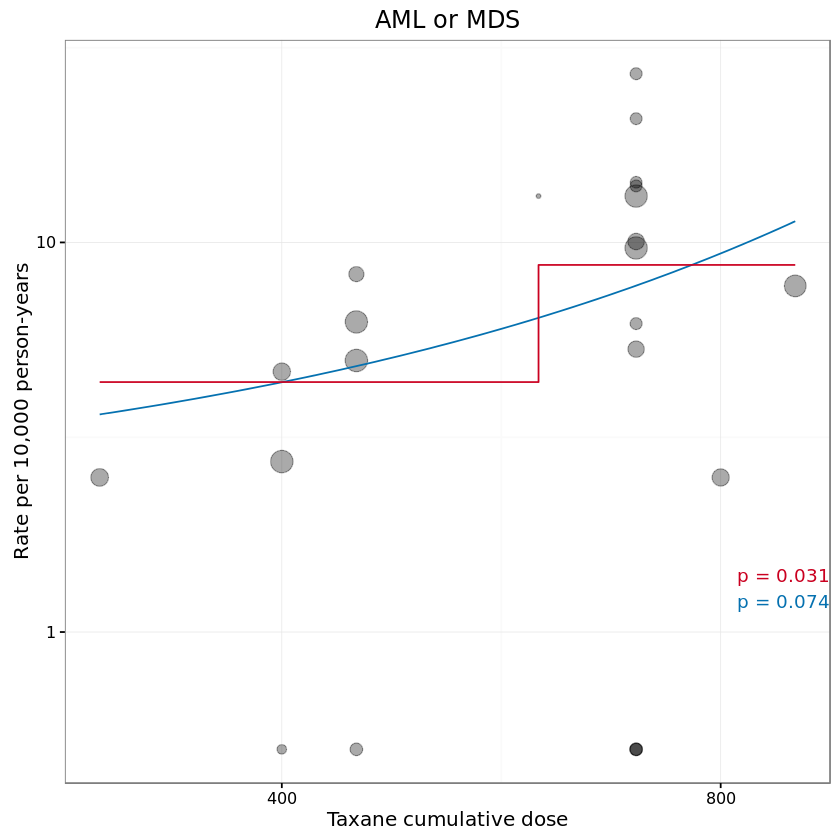

In [27]:
D3 <- D3[, `:=` (drug = "Taxane", x = xTax, xHighDose = xTaxHighDose)]
M <- metareg(D3)
M
plotreg(M,
        D3,
        mal,
        "Taxane cumulative dose",
        1e2 * c(0.5, 1, 2, 4, 8, 16),
        1e2)

### Non-Breast Solid

* Fit the models
* Show model summaries
* Plot the predicted values

**Waiting on a data-check from Meghan (6/22/2016)**

In [28]:
mal <- "Non-Breast Solid"
D3 <- D2[malType == mal]

$rmaLin

Multivariate Meta-Analysis Model (k = 27; method: REML)

Variance Components: 

            estim    sqrt  nlvls  fixed  factor
sigma^2    0.1422  0.3771     14     no      id

Test for Residual Heterogeneity: 
QE(df = 25) = 49.4069, p-val = 0.0025

Test of Moderators (coefficient(s) 2): 
QM(df = 1) = 0.0792, p-val = 0.7784

Model Results:

         estimate      se      zval    pval    ci.lb    ci.ub     
intrcpt   -5.9484  0.2351  -25.2989  <.0001  -6.4092  -5.4875  ***
x          0.0139  0.0492    0.2814  0.7784  -0.0826   0.1104     

---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1 


$rmaBin

Multivariate Meta-Analysis Model (k = 27; method: REML)

Variance Components: 

            estim    sqrt  nlvls  fixed  factor
sigma^2    0.1051  0.3243     14     no      id

Test for Residual Heterogeneity: 
QE(df = 25) = 46.6897, p-val = 0.0053

Test of Moderators (coefficient(s) 2): 
QM(df = 1) = 2.2790, p-val = 0.1311

Model Results:

               estimate 

Saving 6.67 x 6.67 in image


                                      size               mtime
NonBreastSolid_Cyclophosphamide.png 110294 2016-06-25 15:32:04
NonBreastSolid_Cyclophosphamide.csv   3795 2016-06-25 15:32:04


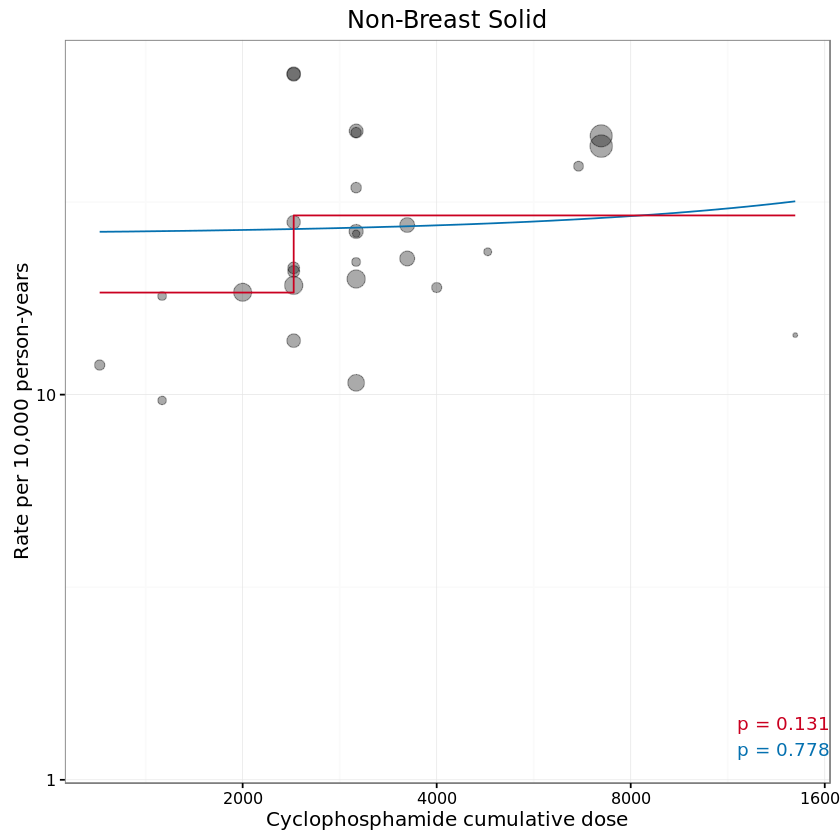

In [29]:
D3 <- D3[, `:=` (drug = "Cyclophosphamide", x = xCyc, xHighDose = xCycHighDose)]
M <- metareg(D3)
M
plotreg(M,
        D3,
        mal,
        "Cyclophosphamide cumulative dose",
        1e3 * c(0.5, 1, 2, 4, 8, 16),
        1e3)

$rmaLin

Multivariate Meta-Analysis Model (k = 8; method: REML)

Variance Components: 

            estim    sqrt  nlvls  fixed  factor
sigma^2    0.2054  0.4532      5     no      id

Test for Residual Heterogeneity: 
QE(df = 6) = 17.0404, p-val = 0.0091

Test of Moderators (coefficient(s) 2): 
QM(df = 1) = 0.3068, p-val = 0.5796

Model Results:

         estimate      se     zval    pval    ci.lb    ci.ub     
intrcpt   -6.4227  0.8958  -7.1695  <.0001  -8.1785  -4.6669  ***
x          0.0838  0.1513   0.5539  0.5796  -0.2128   0.3804     

---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1 


$rmaBin

Multivariate Meta-Analysis Model (k = 8; method: REML)

Variance Components: 

            estim    sqrt  nlvls  fixed  factor
sigma^2    0.1660  0.4074      5     no      id

Test for Residual Heterogeneity: 
QE(df = 6) = 14.7372, p-val = 0.0224

Test of Moderators (coefficient(s) 2): 
QM(df = 1) = 0.8110, p-val = 0.3678

Model Results:

               estimate      se

Saving 6.67 x 6.67 in image


                           size               mtime
NonBreastSolid_Taxane.png 88286 2016-06-25 15:32:05
NonBreastSolid_Taxane.csv  1117 2016-06-25 15:32:05


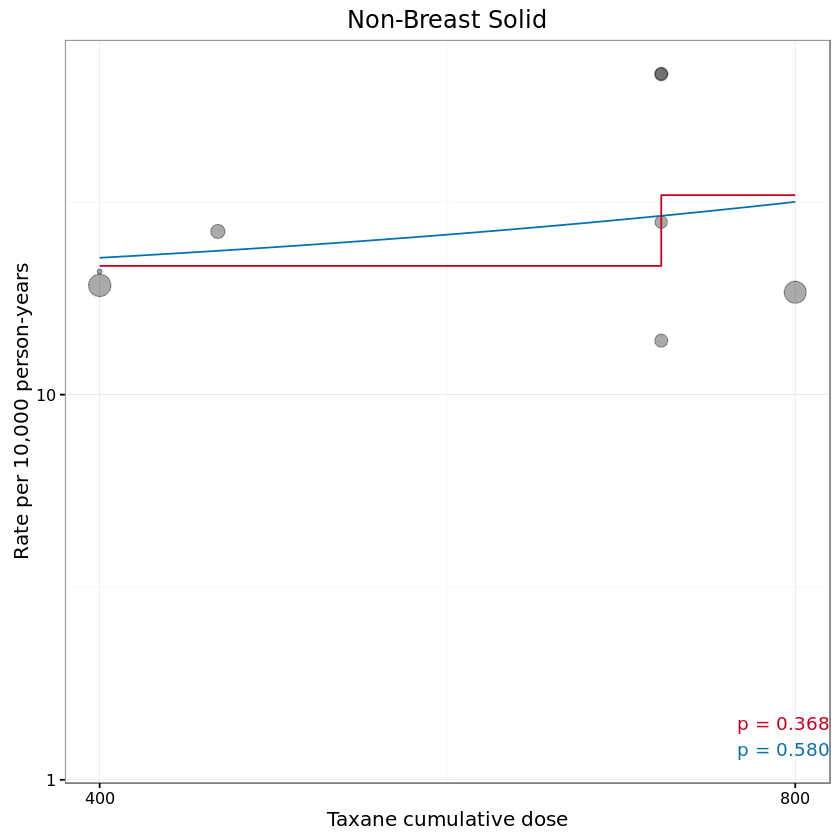

In [30]:
D3 <- D3[, `:=` (drug = "Taxane", x = xTax, xHighDose = xTaxHighDose)]
M <- metareg(D3)
M
plotreg(M,
        D3,
        mal,
        "Taxane cumulative dose",
        1e2 * c(0.5, 1, 2, 4, 8, 16),
        1e2)

## Study Characteristics and Outcomes

Populate Appendix Table 1.
Need columns for

* Study
* Country
* Median follow-up (months)
* Regimen name
* Cumulative dose
    * Anthracyclines
    * Cyclophosphamide
    * Taxanes
* N
* Person-years (the denominator for the incidence rate)
* AML/MDS count (the numerator for the incidence rate)
* AML/MDS incidence, per 10,000 person-years
* Non-breast solid count (the numerator for the incidence rate)
* Non-breast solid incidence, per 10,000 person-years

Output to an Excel workbook, [appendixTableStudyCharacteristicsAndOutcomes.xlsx](appendixTableStudyCharacteristicsAndOutcomes.xlsx).

In [31]:
library(xlsx)
library(IRdisplay)
library(xtable)
T <- D[,
       .(study = ifelse(!is.na(trial), paste(authorYear, trial), authorYear),
         country = NA,
         medianFU = round(medianFU),
         regimen,
         anthrCumulDose = round(anthracyclineCumulDose),
         cycloCumulaDose = round(cyclophosphamideCumulDose),
         taxaneCumulDose = round(taxaneCumulDose),
         nITT,
         py = nITT * (medianFU / 12),
         nAMLOrMDS = malAMLOrMDSTotal,
         incidenceAMLOrMDS = signif(malAMLOrMDSTotal / (nITT * (medianFU / 12)) * scale, digits=3),
         nNonBreastSolid = malNonBreastSolid,
         incidenceNonBreastSolid = signif(malNonBreastSolid / (nITT * (medianFU / 12)) * scale, digits=3))]
write.xlsx(T,
           "appendixTableStudyCharacteristicsAndOutcomes.xlsx",
           row.names=FALSE,
           showNA=FALSE)
file.info("appendixTableStudyCharacteristicsAndOutcomes.xlsx")
T <- xtable(T, digits=c(rep(0, ncol(T) - 3), 0, 2, 0, 2))
display_html(paste(capture.output(print(T, type = 'html')), collapse="", sep=""))

Loading required package: rJava
Loading required package: xlsxjars

Attaching package: ‘xlsx’

The following objects are masked from ‘package:openxlsx’:

    createWorkbook, loadWorkbook, read.xlsx, saveWorkbook, write.xlsx


Attaching package: ‘xtable’

The following object is masked from ‘package:IRdisplay’:

    display



                                                  size isdir mode
appendixTableStudyCharacteristicsAndOutcomes.xlsx 9452 FALSE  664
                                                                mtime
appendixTableStudyCharacteristicsAndOutcomes.xlsx 2016-06-25 15:32:07
                                                                ctime
appendixTableStudyCharacteristicsAndOutcomes.xlsx 2016-06-25 15:32:07
                                                                atime  uid  gid
appendixTableStudyCharacteristicsAndOutcomes.xlsx 2016-06-25 15:21:55 1000 1000
                                                   uname grname
appendixTableStudyCharacteristicsAndOutcomes.xlsx ubuntu ubuntu

,study,country,medianFU,regimen,anthrCumulDose,cycloCumulaDose,taxaneCumulDose,nITT,py,nAMLOrMDS,incidenceAMLOrMDS,nNonBreastSolid,incidenceNonBreastSolid
1,Bergh (2000) SBG 9401,,38,FEC Tailored,,,,251,801,9,112.00,3,37.40
2,Bergh (2000) SBG 9401,,38,FEC CTCb,180,1200,,274,875,0,0.00,1,11.40
3,Bernard-Marty (2003),,73,CMF,,,,255,1551,0,0.00,4,25.80
4,Bernard-Marty (2003),,73,EC,480,4000,,267,1624,0,0.00,3,18.50
5,Bernard-Marty (2003),,73,EC,800,6640,,255,1551,3,19.30,6,38.70
6,Bonneterre (2005) FASG 05,,110,FEC 50,300,3000,,289,2649,1,3.77,9,34.00
7,Bonneterre (2005) FASG 05,,110,FEC 100,600,3000,,276,2530,1,3.95,12,47.40
8,Citron (2003) Intergroup C9741,,36,A-T-C,240,2400,700,484,1452,2,13.80,4,27.50
9,Citron (2003) Intergroup C9741,,36,A-T-C,240,2400,700,493,1479,3,20.30,10,67.60
10,Citron (2003) Intergroup C9741,,36,AC-T,240,2400,700,501,1503,4,26.60,2,13.30


## Session information

In [32]:
sessionInfo()

R version 3.3.0 (2016-05-03)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 14.04.4 LTS

locale:
 [1] LC_CTYPE=en_US.UTF-8          LC_NUMERIC=C                 
 [3] LC_TIME=en_US.UTF-8           LC_COLLATE=en_US.UTF-8       
 [5] LC_MONETARY=en_US.UTF-8       LC_MESSAGES=en_US.UTF-8      
 [7] LC_PAPER=en_US.UTF-8          LC_NAME=en_US.UTF-8          
 [9] LC_ADDRESS=en_US.UTF-8        LC_TELEPHONE=en_US.UTF-8     
[11] LC_MEASUREMENT=en_US.UTF-8    LC_IDENTIFICATION=en_US.UTF-8

attached base packages:
[1] tools     stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] xtable_1.8-2         IRdisplay_0.3.0.9000 xlsx_0.5.7          
 [4] xlsxjars_0.6.1       rJava_0.9-6          RColorBrewer_1.1-2  
 [7] ggplot2_2.1.0        metafor_1.9-8        Matrix_1.2-6        
[10] data.table_1.9.6     openxlsx_3.0.0      

loaded via a namespace (and not attached):
 [1] Rcpp_0.12.5      magrittr_1.5     munsell_0.4.3    uuid_0.1-